# Modelo de Machine Learning: Previsão de Satisfação do Cliente


**Objetivo do Projeto:** Desenvolvi um modelo de classificação que consegue prever, analisando os dados de um pedido, se um cliente vai ficar insatisfeito - ou seja, dar notas 1, 2 ou 3 na avaliação.

**Por Que Isso Importa para a Empresa:** Esse modelo é estratégico porque vai permite agir antes que o problema acontece. Quando identificado um pedido com alta chance de gerar insatisfação, podemos tomar medidas proativas - como entrar em contato com o cliente, resolver possíveis problemas ou oferecer algum benefício - para transformar uma experiência negativa em positiva antes mesmo dela se concretizar.

**Metodologia:** O projeto segue o pipeline padrão de Machine Learning: preparação dos dados, engenharia de atributos, pré-processamento, treinamento do modelo, avaliação e interpretação dos resultados.

In [1]:
# ---  1: SETUP INICIAL ---

# Importando as bibliotecas que vou utilizar:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# --- 2: CARREGAMENTO E CRIAÇÃO DO DATAFRAME COMPLETO ---
# Para este notebook de Machine Learning, vou recriar o Dataframe mestre de forma limpa.

# O caminho da pasta onde os arquivos .csv estão guardados:
caminho_da_pasta = r"C:\Users\User\Desktop\Pasta de projeto Kaggle\Analise_E-commerce\dados"

# Dicionário com os nomes dos arquivos que preciso:
nomes_dos_arquivos = {
    'customers': 'olist_customers_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'order_payments': 'olist_order_payments_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv'
}

In [3]:
# --- 3: CARREGANDO OS ARQUIVOS E CRIANDO UM MERGE ---

# Carregando cada arquivo em um Dataframe do pandas
dataframes = {}
print("Carregando os dados...")
for nome_df, nome_arquivo in nomes_dos_arquivos.items():
    caminho_completo = os.path.join(caminho_da_pasta, nome_arquivo)
    dataframes[nome_df] = pd.read_csv(caminho_completo)
print("\nDADOS CARREGADO COM SUCESSO!")

# ---------------------------------------------------------------------------

# Juntando (merge) as tabelas para criar o DataFrame mestre
df_merged = pd.merge(dataframes['orders'], dataframes['customers'], on='customer_id', how='left')
df_completo = pd.merge(df_merged, dataframes['order_payments'], on='order_id', how='left')
df_completo = pd.merge(df_completo, dataframes['order_items'], on='order_id', how='left')
df_completo = pd.merge(df_completo, dataframes['products'], on='product_id', how='left')
df_final = pd.merge(df_completo, dataframes['order_reviews'], on='order_id', how='left')

# Convertendo as colunas de data, que são essenciais
colunas_de_data = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in colunas_de_data:
    df_final[col] = pd.to_datetime(df_final[col], errors='coerce') # 'errors=coerce' transforma datas inválidas em Nulo (NaN)

print("\nDATAFRAME FINAL ('df_final') CRIADO COM SUCESSO!")

Carregando os dados...

DADOS CARREGADO COM SUCESSO!

DATAFRAME FINAL ('df_final') CRIADO COM SUCESSO!


     Definido o problema e a variável

In [4]:
# --- 4: DEFINIÇÃO DO PROBLEMA E VARIÁVEL ALVO ---

# 1. Objetivo é prever a insatisfação. Vou definir "insatisfeito" como uma nota de avaliação de 1, 2 ou 3.

# 2. A função .apply() passa por cada valor da coluna 'review_score' e aplica uma regra.

# 3. A regra (lambda x: ...) diz: "se o valor (x) for menor ou igual a 3, retorne 1. Senão, retorne 0."
df_final['insatisfeito'] = df_final['review_score'].apply(lambda x: 1 if x <= 3 else 0)

print("\nCOLUNA 'insatisfeito' (variável alvo) CRIOADA COM SUCESSO!.")



COLUNA 'insatisfeito' (variável alvo) CRIOADA COM SUCESSO!.


In [5]:
# --- 5: JUNTAR OS DADOS DOS VENDEDORES ---

# Esta Vai juntar a tabela de vendedores.
print("--- INCLUÍDO DADOS DOS VENDEDORES... ---")
df_sellers = dataframes['sellers']
df_final_com_sellers = pd.merge(df_final, df_sellers, on='seller_id', how='left')
print("\nDADOS DOS VENDEDORES INCLUÍDOS COM SUCESSO!")

--- INCLUÍDO DADOS DOS VENDEDORES... ---

DADOS DOS VENDEDORES INCLUÍDOS COM SUCESSO!


In [6]:
# --- 6: ENGENHARIA E SELEÇÃO DE ATRIBUTOS (FEATURES) ---

# Criando as features de tempo onde na EDA mostrou na análise ser muito importantes:
df_final_com_sellers['tempo_de_entrega'] = (df_final_com_sellers['order_delivered_customer_date'] - df_final_com_sellers['order_purchase_timestamp']).dt.days
df_final_com_sellers['diferenca_estimativa_entrega'] = (df_final_com_sellers['order_delivered_customer_date'] - df_final_com_sellers['order_estimated_delivery_date']).dt.days

# Aqui vou selecionar as 'pistas' (features) que darei ao modelo para ele aprender.
# É uma combinação de informações sobre o pagamento, a logística, o produto e a localização:
features = [
    'payment_value',               # Valor do pagamento
    'freight_value',               # Valor do frete
    'tempo_de_entrega',            # Dias que demorou para entregar
    'diferenca_estimativa_entrega',# Dias de atraso/adianto
    'payment_installments',        # Número de parcelas
    'product_category_name',       # Categoria do produto
    'customer_state',              # Estado do cliente
    'seller_state'                 # Estado do vendedor
]

alvo = 'insatisfeito' # O nome da variável alvo

# Criando um Dataframe final para o modelo.
# O 'df_final_com_sellers' tem todas as colunas.
df_model = df_final_com_sellers[features + [alvo]].dropna()

print(f"\nDATAFRAME PARA O MODELO CRIADO COM {len(df_model)} AMOSTRA (linhas completas).")
print("\n--- AMOSTRA DO DATAFRAME DO MODELO ('df_model') ---")
df_model.head()


DATAFRAME PARA O MODELO CRIADO COM 114081 AMOSTRA (linhas completas).

--- AMOSTRA DO DATAFRAME DO MODELO ('df_model') ---


,payment_value,freight_value,tempo_de_entrega,diferenca_estimativa_entrega,payment_installments,product_category_name,customer_state,seller_state,insatisfeito
0,18.12,8.72,8.0,-8.0,1.0,utilidades_domesticas,SP,SP,0
1,2.00,8.72,8.0,-8.0,1.0,utilidades_domesticas,SP,SP,0
2,18.59,8.72,8.0,-8.0,1.0,utilidades_domesticas,SP,SP,0
3,141.46,22.76,13.0,-6.0,1.0,perfumaria,BA,SP,0
4,179.12,19.22,9.0,-18.0,3.0,automotivo,GO,SP,0


### Pré-processamento: Convertendo Texto em Números

Modelos de Machine Learning são algoritmos matemáticos e não entendem texto (como 'SP' ou 'cama_mesa_banho'). 
Portanto, foi preciso transformar as features categóricas em um formato numérico. Para isso, utilizei técnica de **One-Hot Encoding**.

In [7]:
# --- 7: PRÉ-PROCESSAMENTO (One-Hot Encoding) ---

print("INIICIANDO O PRÉ-PROCESSAMENTO PARA TRASNFORMAR TEXTO EM NÚMEROS...")

# Utilizando a prática padrão para separar 'pistas' (chamadas de X) do 'alvo' (chamado de y).
# X são todas as colunas que o modelo usará para aprender.
# y é a coluna que o modelo tentará prever.
X = df_model.drop('insatisfeito', axis=1)
y = df_model['insatisfeito']

# Com pandas vou identificar automaticamente quais colunas são de texto:
colunas_categoricas = X.select_dtypes(include=['object']).columns
print(f"\nESSAS SÃO AS COLUNAS DE TEXTO QUE SERÃO TRASNFOMARDAS: {list(colunas_categoricas)}")

# O pd.get_dummies() faz o One-Hot Encoding.
# Ele pega o DataFrame X e transforma apenas as colunas de texto que foi especificada:
X_encoded = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# O 'drop_first=True' é uma boa prática em ML. Ele remove uma das categorias de cada feature
# para evitar redundância de informação, o que pode ajudar alguns modelos.

print(f"\nPRÉ-PROCESSAMENTO CONCLUÍDO!")
print(f"O número de colunas (features) aumentou de {len(X.columns)} para {len(X_encoded.columns)}.")

print("\n--- Amostra do DataFrame 100% Numérico ('X_encoded') ---")
# Note como 'product_category_name_automotivo', 'customer_state_ES', etc., apareceram.
X_encoded.head()

INIICIANDO O PRÉ-PROCESSAMENTO PARA TRASNFORMAR TEXTO EM NÚMEROS...

ESSAS SÃO AS COLUNAS DE TEXTO QUE SERÃO TRASNFOMARDAS: ['product_category_name', 'customer_state', 'seller_state']

PRÉ-PROCESSAMENTO CONCLUÍDO!
O número de colunas (features) aumentou de 8 para 124.

--- Amostra do DataFrame 100% Numérico ('X_encoded') ---


,payment_value,freight_value,tempo_de_entrega,diferenca_estimativa_entrega,payment_installments,product_category_name_alimentos,product_category_name_alimentos_bebidas,product_category_name_artes,product_category_name_artes_e_artesanato,product_category_name_artigos_de_festas,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,18.12,8.72,8.0,-8.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2.00,8.72,8.0,-8.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,18.59,8.72,8.0,-8.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,141.46,22.76,13.0,-6.0,1.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,179.12,19.22,9.0,-18.0,3.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


### Divisão em Treino e Teste: (Train-Test Split).

Para avaliar o modelo de forma justa, não posso testá-lo com os mesmos dados que utilizei para treiná-lo. Isso seria como dar as respostas da prova para o aluno antes. Por isso, dividir o dataset em um conjunto de treino (80%) e um conjunto de teste (20%).

In [ ]:
# --- 8: DIVISÃO DE DADOS EM TREINO E TESTE ---

from sklearn.model_selection import train_test_split 

print("--- INICIANDO A DIVISÃO DOS DADOS EM CONJUTOS DE TREINOS E TESTE... ---")

# A função train_test_split é a ferramenta para isso.
# Ela vai embaralhar os dados e dividi-los.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, 
    y, 
    test_size=0.2,    # Aqui define que 20% dos dados serão para o conjunto de TESTE. Os 80% restantes serão para TREINO.
    random_state=42   # Este número é embaralhamento. Usar o mesmo número
                      # garante que a divisão seja sempre a mesma toda vez que rodar o código.
                      # Isso é CRUCIAL para que o resultados sejam reprodutíveis. 42 é uma convenção clássica.
)

print("\nDIVISÃO CONCLUÍDA COM SUCESSO!")

# --- 10: VERIFICAÇÃO ---

# Vai verificar os "shapes" (formatos) dos novos Dataframes para confirmar que a divisão funcionou.
print(f"\nFormato de X_train (pistas de treino): {X_train.shape}")
print(f"Formato de y_train (alvos de treino):  {y_train.shape}")
print(f"Formato de X_test (pistas de teste):   {X_test.shape}")
print(f"Formato de y_test (alvos de teste):    {y_test.shape}")

--- INICIANDO A DIVISÃO DOS DADOS EM CONJUTOS DE TREINOS E TESTE... ---

DIVISÃO CONCLUÍDA COM SUCESSO!

Formato de X_train (pistas de treino): (91264, 124)
Formato de y_train (alvos de treino):  (91264,)
Formato de X_test (pistas de teste):   (22817, 124)
Formato de y_test (alvos de teste):    (22817,)


    TREINO DO MODELO (RandomForestClassifier)

In [ ]:
# --- 9: TREINANDO O MODELO ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # Usaremos isso no próximo passo!

# --- TREINAMENTO DO MODELO DE MACHINE LEARNING ---

print("--- INICIANDO O TREINAMENTO DO MODELO ---> RandomForest ---")

# 1. Criando o modelo:
#    - n_estimators=100: Diz que a 'floresta' terá 100 'árvores'.
#    - random_state=42: Garante que o resultado seja o mesmo toda vez que rodar. Consistência é chave!
#    - n_jobs=-1: Diz ao modelo para usar todos os processadores do computador para treinar mais rápido.
modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)


# 2. O Processo de Treinamento:
#    A função .fit() é o coração do Machine Learning. É aqui onde o modelo vai "lê" as pistas (X_train) e as respostas (y_train) para aprender os padrões.
modelo.fit(X_train, y_train)


print("\n✅ TREINAMENTO CONCLUÍDO COM SUCESSO!")

# O que temos agora? A variável 'modelo' não é mais um aluno vazio.
# Agora, ele é um 'aluno treinado', pronto para ser testado na 'prova final'.

--- INICIANDO O TREINAMENTO DO MODELO ---> RandomForest ---

✅ TREINAMENTO CONCLUÍDO COM SUCESSO!


    AVALIANDO O MODELO COM DADOS DE TESTE

In [10]:
# --- 10: AVALIAÇÃO DO MODELO COM DADOS DE TESTE ---

from sklearn.metrics import accuracy_score

print("--- INICIANDO A AVALIAÇÃO DO MODELO NO CONJUTO DE TESTE ---")

# 1. Fazendo as Previsões:
#    Usarei a função .predict() para pedir ao modelo treinado que me dê. As previsões para os dados de teste (X_test).
previsoes = modelo.predict(X_test)


# 2. Calculando a Acurácia:
#    Aqui vou compar as previsões que o modelo fez ('previsoes') com as respostas corretas que já tínha ('y_test').
#    A função accuracy_score faz essa comparação para dá a porcentagem dos acertos.
acuracia = accuracy_score(y_test, previsoes)


print("\n--- PERFORMANCE DO MODELO ---")

# Multiplicarei por 100 e formatarei para ficar em formato de porcentagem.
print(f"A acurácia do primeiro modelo é: {acuracia * 100:.2f}%")

# Obs: O que isso significa?
# Ex: Se der 90.00%, significa que o modelo acertou a previsão (satisfeito/insatisfeito)
# para 90% dos clientes no conjunto de teste.

--- INICIANDO A AVALIAÇÃO DO MODELO NO CONJUTO DE TESTE ---

--- PERFORMANCE DO MODELO ---
A acurácia do primeiro modelo é: 85.06%


In [11]:
# 11: VERIFICANDO A DISTRIBUIÇÃO DO GABARITO DE TESTE --- 
print(y_test.value_counts(normalize=True))

insatisfeito
0    0.76947
1    0.23053
Name: proportion, dtype: float64


    Matriz de Confusão

Gerando a Matriz de Confusão para entender os tipos de erro...


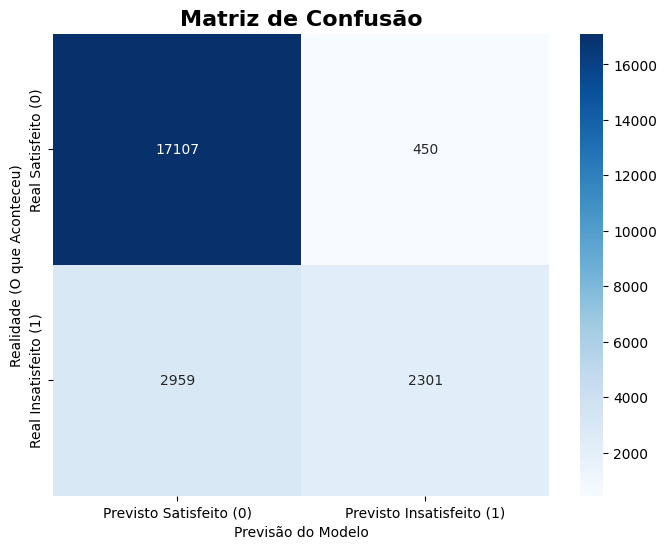

In [12]:
# --- MATRIZ DE CONFUSÃO ---

from sklearn.metrics import confusion_matrix
import seaborn as sns

# --- 12: ANÁLISE PROFUNDA DOS ERROS (Matriz de Confusão) ---

print("Gerando a Matriz de Confusão para entender os tipos de erro...")

# A função confusion_matrix vai cria a tabela de resultados 2x2
cm = confusion_matrix(y_test, previsoes)

# Criando o gráfico com Seaborn para uma visualização clara (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto Satisfeito (0)', 'Previsto Insatisfeito (1)'],
            yticklabels=['Real Satisfeito (0)', 'Real Insatisfeito (1)'])

plt.title('Matriz de Confusão', fontsize=16, fontweight='bold')
plt.ylabel('Realidade (O que Aconteceu)')
plt.xlabel('Previsão do Modelo')
plt.show()

    RELATÓRIO DE CLASSIFICAÇÃO

In [13]:
# --- 13: MÉTRICAS AVANÇADAS DE PERFORMANCE ---

from sklearn.metrics import classification_report

print("--- GERANDO O RELATÓRIO DE CLASSIFICAÇÃO DETALHADO ---")

# A função classification_report vai da a Precisão, Revocação e F1-Score para cada classe.
# Classe 0 = Satisfeito
# Classe 1 = Insatisfeito
report = classification_report(y_test, previsoes)

print(report)

--- GERANDO O RELATÓRIO DE CLASSIFICAÇÃO DETALHADO ---
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     17557
           1       0.84      0.44      0.57      5260

    accuracy                           0.85     22817
   macro avg       0.84      0.71      0.74     22817
weighted avg       0.85      0.85      0.83     22817



### Refinamento: Lidando com o Desbalanceamento de Classes com SMOTE

Na primeira avaliação o modelo mostrou dificuldade em identificar a classe minoritária (clientes insatisfeitos). Isso ocorreu porque o dataset é desbalanceado. Para tentar corrigir isso, apliquei a técnica **SMOTE (Synthetic Minority Over-sampling Technique)**, que cria exemplos sintéticos da classe minoritária no conjunto de treino, forçando o modelo a aprender seus padrões de forma mais robusta.

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import collections

# --- 14: Balanceando os Dados de Treino com SMOTE ---

print("Balanceando o conjunto de treino com SMOTE...")
print(f"Composição original do treino: {collections.Counter(y_train)}")

# 1. Criando um "personal trainer"😁 SMOTE
smote = SMOTE(random_state=42)

# 2. Aplicando o SMOTE APENAS nos dados de treino
#    O .fit_resample() irá criar os novos exemplos sintéticos
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Composição do treino após o SMOTE: {collections.Counter(y_train_resampled)}")
print("Conjunto de treino balanceado com sucesso!")

# --------------------------------------------------------------------------------------------

# --- 15: TREINANDO UM NOVO MODELO COM OS DADOS BALANCEADOS ---

print("\nIniciando o treinamento do MODELO COM SMOTE...")

modelo_smote = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

# Treinando o novo modelo com os dados "turbinados" pelo SMOTE
modelo_smote.fit(X_train_resampled, y_train_resampled)
print("✅ Treinamento concluído!")


# --- AVALIAÇÃO DO MODELO SMOTE ---
print("\n--- Avaliando o Modelo com SMOTE ---")
previsoes_smote = modelo_smote.predict(X_test)
acuracia_smote = accuracy_score(y_test, previsoes_smote)
report_smote = classification_report(y_test, previsoes_smote)

print(f"A NOVA acurácia do modelo com SMOTE é: {acuracia_smote * 100:.2f}%")
print("\nNOVO Relatório de Classificação:")
print(report_smote)

Balanceando o conjunto de treino com SMOTE...
Composição original do treino: Counter({0: 70275, 1: 20989})
Composição do treino após o SMOTE: Counter({0: 70275, 1: 70275})
Conjunto de treino balanceado com sucesso!

Iniciando o treinamento do MODELO COM SMOTE...
✅ Treinamento concluído!

--- Avaliando o Modelo com SMOTE ---
A NOVA acurácia do modelo com SMOTE é: 84.38%

NOVO Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.96      0.90     17557
           1       0.77      0.46      0.58      5260

    accuracy                           0.84     22817
   macro avg       0.81      0.71      0.74     22817
weighted avg       0.84      0.84      0.83     22817



    Análise de Importância de Features (Feature Importance).

Extraindo os fatores mais importantes que o modelo aprendeu...


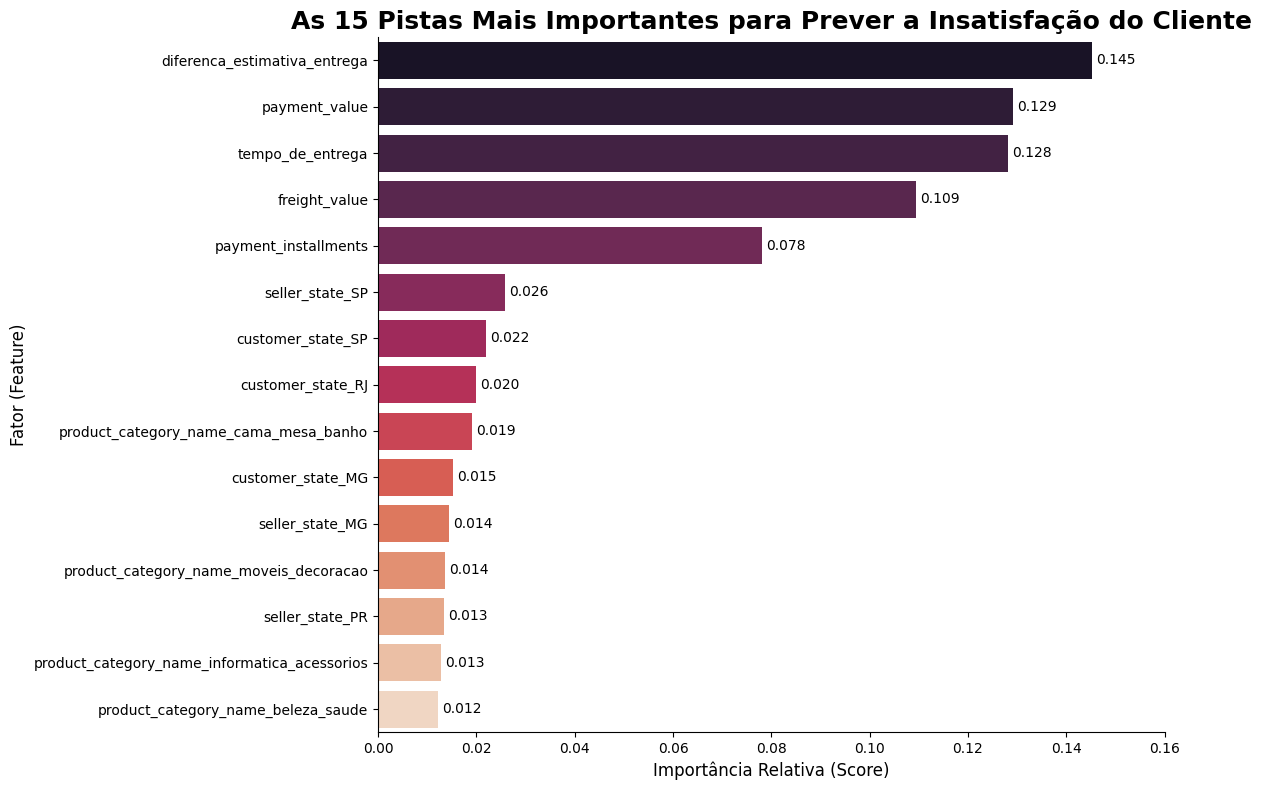


--- Top 15 Fatores de Insatisfação ---
                                          Feature  Importance
3                    diferenca_estimativa_entrega    0.145201
0                                   payment_value    0.129238
2                                tempo_de_entrega    0.128115
1                                   freight_value    0.109408
4                            payment_installments    0.078143
123                               seller_state_SP    0.025853
101                             customer_state_SP    0.021968
94                              customer_state_RJ    0.019877
17          product_category_name_cama_mesa_banho    0.019066
86                              customer_state_MG    0.015240
109                               seller_state_MG    0.014427
58         product_category_name_moveis_decoracao    0.013629
116                               seller_state_PR    0.013463
48   product_category_name_informatica_acessorios    0.012808
15             product_categor

In [ ]:
# --- 16: INTERPRETANDO O MODELO (Feature Importance) ---

# --- INTERPRETAÇÃO DO MODELO E INSIGHTS DE NEGÓCIO ---
print("Extraindo os fatores mais importantes que o modelo aprendeu...")

# 1. Extraindo a importância de cada feature do modelo treinado:
# O atributo .feature_importances_ vai me dá um score para cada uma das 124 colunas.
importances = modelo_smote.feature_importances_

# 2. Criando um Dataframe para facilitar a visualização:
# Juntando os nomes das colunas com seus respectivos scores de importância.
feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Pegando apenas as 15 features mais importantes para o gráfico:
top_15_features = feature_importance_df.head(15)


# --- Visualização ---
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=top_15_features,
    palette='rocket',
    hue='Feature',
    legend=False,
    orient='h'
)

# Títulos e design
plt.title('As 15 Pistas Mais Importantes para Prever a Insatisfação do Cliente', fontsize=18, fontweight='bold')
plt.xlabel('Importância Relativa (Score)', fontsize=12)
plt.ylabel('Fator (Feature)', fontsize=12)
sns.despine()

# Adicionando os valores exatos nas barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

ax.set_xlim(0, ax.get_xlim()[1] * 1.05)
plt.tight_layout()
plt.show()

print("\n--- Top 15 Fatores de Insatisfação ---")
print(top_15_features)

### Conclusão e Insights do Modelo

**Conclusão:** O gráfico de importância de features confirma a principal descoberta da EDA: o **tempo de entrega** é, de longe, o fator mais importante para prever a insatisfação do cliente. Fatores como o valor do frete e o atraso em relação à estimativa também são altamente relevantes.

**Recomendação Acionável:** A principal recomendação de negócio é que a empresa foque em otimizar sua logística para reduzir o tempo de entrega. Investimentos nessa área terão o maior impacto direto na satisfação e retenção de clientes.

## FIM
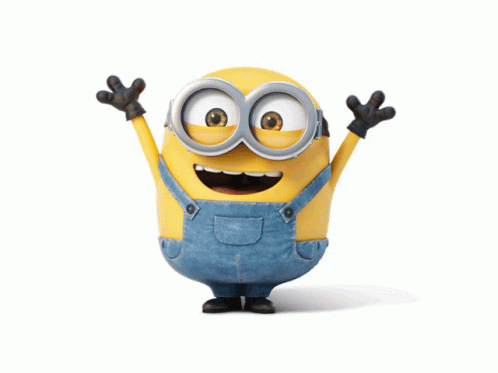